# Creating Cartographic Congressional Districts

In [1]:
import pandas as pd
import geopandas as gpd
import topojson as tp
import json
import matplotlib.pyplot as plt
import us

## GeoPandas
- State data from [```us```](https://github.com/unitedstates/python-us) package.
- Only include 50 states + DC

### Congressional Districts and States
- Congressional district and State Shapefiles [US Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html).

In [2]:
cd = gpd.read_file('../cb_2019_us_cd116_5m/cb_2019_us_cd116_5m.shp')
st = gpd.read_file('../cb_2019_us_state_5m/cb_2019_us_state_5m.shp')

In [3]:
cd.head(3)

,STATEFP,CD116FP,AFFGEOID,GEOID,LSAD,CDSESSN,ALAND,AWATER,geometry
0,06,46,5001600US0646,0646,C2,116,187083592,995827,"POLYGON ((-118.01098 33.83197, -117.99790 33.8..."
1,53,08,5001600US5308,5308,C2,116,19060921511,369956145,"POLYGON ((-122.55184 46.96594, -122.52653 46.9..."
2,28,03,5001600US2803,2803,C2,116,33034109746,341716865,"POLYGON ((-91.65501 31.25181, -91.65403 31.255..."


In [4]:
st.head(3)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,23,01779787,0400000US23,23,ME,Maine,00,79887659040,11745717739,"MULTIPOLYGON (((-68.37659 44.11376, -68.37538 ..."
1,33,01779794,0400000US33,33,NH,New Hampshire,00,23189198255,1026903434,"POLYGON ((-72.55725 42.85302, -72.55423 42.860..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5046620081,1399291164,"MULTIPOLYGON (((-75.57080 39.62677, -75.55945 ..."


In [5]:
# Merge GeoDataFrames on state FIPS code
df = pd.merge(cd, st, on='STATEFP', how='left', suffixes=('_cd', '_state'))

In [6]:
# Only keep 50 states + DC
states = [ state.abbr for state in us.states.STATES ] + ['DC']
df = df.loc[df['STUSPS'].isin(states)]

### Parallels and Geographic Centers for Projections
- Create features for Albers projections:
    - State Latitude Parallels
    - State Lat-Long Centers relative to prime meridian

In [8]:
df['state_parallels'] = df['geometry_state'].bounds[['miny', 'maxy']].values.tolist()
df['state_parallels'] = df['state_parallels'].map(lambda x: str(x))
df['state_center'] = df['geometry_state'].centroid.map(lambda x: x.bounds[:2])
df['state_center'] = df['state_center'].map(lambda x: str(list(x)))

<ipython-input-8-1eb0f1cbe1c1>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['state_center'] = df['geometry_state'].centroid.map(lambda x: x.bounds[:2])


In [9]:
col_dict = {
    'CD116FP': 'cd116',
    'STUSPS': 'state_abbr',
    'NAME': 'state',
    'geometry_cd': 'geometry'
}
df.rename(columns=col_dict, inplace=True)

In [10]:
df = df[['state', 'state_abbr', 'cd116', 'state_parallels', 'state_center', 'geometry']]

In [13]:
df.head(3)

,state,state_abbr,cd116,state_parallels,state_center,geometry
0,California,CA,46,"[32.534155999999996, 42.009518]","[-119.61056021596366, 37.24595553055751]","POLYGON ((-118.01098 33.83197, -117.99790 33.8..."
1,Washington,WA,08,"[45.543541, 49.002494]","[-120.45086015401453, 47.38228437070155]","POLYGON ((-122.55184 46.96594, -122.52653 46.9..."
2,Mississippi,MS,03,"[30.173942999999998, 34.996052]","[-89.66427750479714, 32.74881844210875]","POLYGON ((-91.65501 31.25181, -91.65403 31.255..."


In [15]:
# Generate TopoJSON files of individual states
states = list(df['state_abbr'].unique())
error = []
for state in states:
    try:
        topo = tp.Topology(data=df.loc[df['state_abbr'] == state])
    except:
        error.append(state)
    topo.to_json(f'./data/{state}.topo.json')

## National Map with States
- Downloaded data from composite Albers [TopoJSON GitHub](https://github.com/topojson/us-atlas#states-10m.json).

In [21]:
usa = gpd.read_file('./data/usa.topo.json')

In [22]:
usa.head(3)

,id,name,geometry
0,01,Alabama,"MULTIPOLYGON (((647.959 492.438, 651.817 491.5..."
1,02,Alaska,"MULTIPOLYGON (((104.168 551.602, 104.645 550.2..."
2,04,Arizona,"POLYGON ((145.070 407.049, 145.730 406.740, 14..."


In [35]:
# Map FIPS code to state abbreviation
fips_dict = { state.fips: state.abbr for state in us.states.STATES }
usa['id'] = usa['id'].map(fips_dict)

In [38]:
# Find DC
usa.loc[usa['id'].isna()]

,id,name,geometry
27,NaN,District of Columbia,"POLYGON ((825.883 266.995, 826.959 265.345, 82..."


In [39]:
# Add DC
usa.at[27, 'id'] = 'DC'

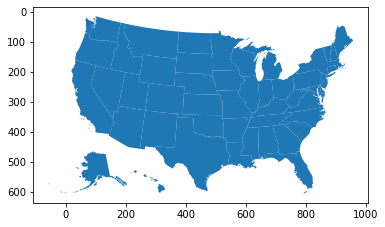

In [41]:
# TopoJSON state data is mapped to SVG, the top-left corner is origin
usa.plot().invert_yaxis()

In [46]:
topo = tp.Topology(data=usa)
topo.to_json('./data/usa.topo.json')